# Audio Signals Analysis
This notebook processes audio signals that accompanied the text of the dataset and performs audio signals analysis techniques, including the development of a Convolutional Neural network model that processes the audio signals information.

In [ ]:
#!pip install librosa pandas numpy matplotlib tensorflow seaborn plotly

In [2]:
# Import necessary libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import os
import pandas as pd
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Load and Process Dataset

Define the path to the dataset and process each actor directory to extract emotion, gender, and file paths.


In [3]:
# Define the path to the dataset
RAV = 'ravdess-emotional-speech-audio/audio_speech_actors_01-24/'
dir_list = os.listdir(RAV)

# Initialize lists to store emotion, gender, and file paths
emotion = []
gender = []
path = []

# Process each actor directory
for i in dir_list:
    actor_path = os.path.join(RAV, i)
    if not os.path.isdir(actor_path):
        continue  # Skip if it's not a directory
    fname = os.listdir(actor_path)
    for f in fname:
        if f == '.DS_Store':
            continue  # Skip the .DS_Store file
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        gender.append("female" if temp % 2 == 0 else "male")
        path.append(os.path.join(actor_path, f))

# Create a DataFrame to store the data
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df], axis=1)
RAV_df.columns = ['gender', 'emotion']
RAV_df['labels'] = RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df, pd.DataFrame(path, columns=['path'])], axis=1)
RAV_df = RAV_df.drop(['gender'], axis=1)

# Display the DataFrame
display(RAV_df.head())
display(RAV_df.describe())

,emotion,labels,source,path
0,neutral,male_neutral,RAVDESS,ravdess-emotional-speech-audio/audio_speech_ac...
1,neutral,male_neutral,RAVDESS,ravdess-emotional-speech-audio/audio_speech_ac...
2,neutral,male_neutral,RAVDESS,ravdess-emotional-speech-audio/audio_speech_ac...
3,neutral,male_neutral,RAVDESS,ravdess-emotional-speech-audio/audio_speech_ac...
4,neutral,male_neutral,RAVDESS,ravdess-emotional-speech-audio/audio_speech_ac...


,emotion,labels,source,path
count,1440,1440,1440,1440
unique,7,14,1,1440
top,neutral,male_neutral,RAVDESS,ravdess-emotional-speech-audio/audio_speech_ac...
freq,288,144,1440,1


## Visualize Audio Data

Create a waveplot for an example audio file.


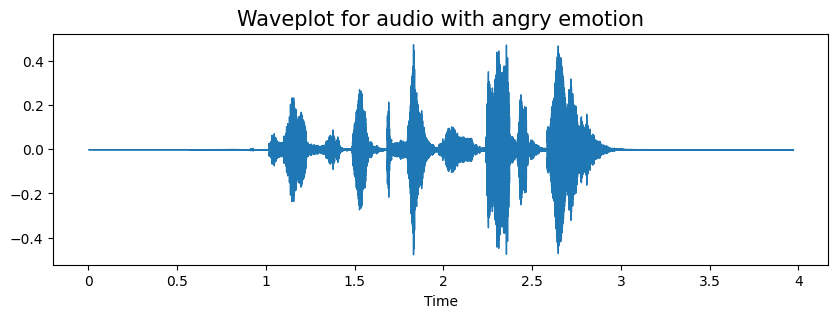

In [3]:
# Import IPython display for audio playback
import IPython.display as ipd

# Function to create a waveplot for audio files
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

# Example waveplot and audio playback
emotion = 'angry'
path = np.array(RAV_df.path[RAV_df.emotion == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)

# Play the audio file
ipd.Audio(path)

## Audio Data Augmentation

Define functions for data augmentation, including adding noise, stretching, shifting, and pitch adjustment.


In [4]:
# Audio data augmentation functions
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

## Feature Extraction

Define functions for extracting features from audio data, including ZCR, Chroma STFT, MFCC, RMS, and Mel Spectrogram.


In [5]:
# Feature extraction function
def extract_features(data, sample_rate):
    result = np.array([])
    
    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))
    
    # Chroma STFT
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))
    
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))
    
    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))
    
    # Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    
    return result

# Function to get features from an audio file path
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # Data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))
    
    # Data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3))
    
    return result

## Data Preparation

Prepare the data by extracting features, encoding labels, and splitting into training and testing sets.


In [6]:
# Data Preparation
X, Y = [], []
for path, emotion in zip(RAV_df.path, RAV_df.emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

# Convert features and labels to DataFrame
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

display(Features.head())
display(Features.describe())

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.321275,0.729664,0.750032,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753972,...,4.310903e-06,3.291511e-06,2.148075e-06,2.279739e-06,5.116493e-06,8.190282e-06,0.000007,0.000005,4.245834e-07,neutral
1,0.288430,0.772852,0.802861,0.782342,0.780048,0.778848,0.696614,0.674800,0.715376,0.747580,...,8.392011e-06,8.006866e-06,6.812527e-06,6.968781e-06,9.736803e-06,1.271389e-05,0.000012,0.000009,4.716273e-06,neutral
2,0.188256,0.622125,0.699214,0.753343,0.721212,0.701727,0.682356,0.662828,0.686486,0.733960,...,8.579052e-07,9.576654e-07,7.733596e-07,5.233101e-07,3.592860e-07,9.261693e-07,0.000002,0.000001,7.753986e-08,neutral
3,0.293566,0.673896,0.722096,0.723508,0.682302,0.680533,0.675352,0.628977,0.679179,0.707283,...,6.984504e-06,7.034949e-06,6.654923e-06,6.979548e-06,1.214236e-05,9.640184e-06,0.000011,0.000006,4.254087e-07,neutral
4,0.329757,0.784105,0.823842,0.816384,0.790406,0.810876,0.757912,0.659232,0.696618,0.745273,...,1.466285e-04,1.431777e-04,1.415865e-04,1.469682e-04,1.583053e-04,1.584611e-04,0.000159,0.000142,1.414108e-04,neutral


,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
count,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,...,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03
mean,0.210674,0.627973,0.630923,0.635956,0.645917,0.634980,0.606049,0.600373,0.620142,0.637427,...,1.749076e-03,1.763267e-03,1.805149e-03,1.839931e-03,1.882626e-03,1.916236e-03,1.920899e-03,1.874215e-03,1.377022e-03,7.499168e-04
std,0.068901,0.088396,0.097949,0.101073,0.102701,0.105246,0.091601,0.078885,0.080895,0.079293,...,6.217479e-03,6.287770e-03,6.469430e-03,6.681399e-03,6.901422e-03,6.889261e-03,6.807199e-03,6.477294e-03,5.384920e-03,4.390796e-03
min,0.060041,0.339261,0.287358,0.274466,0.261137,0.263631,0.269492,0.262952,0.242527,0.269619,...,2.135674e-08,1.693105e-08,2.129188e-08,2.401496e-08,2.901139e-08,2.325078e-08,6.040970e-08,7.742658e-08,3.496133e-08,2.158315e-09
25%,0.154567,0.569434,0.564822,0.565290,0.574195,0.564306,0.548989,0.553570,0.568663,0.585914,...,2.859983e-05,2.916063e-05,3.012701e-05,3.173867e-05,3.484984e-05,3.468919e-05,3.461263e-05,3.365083e-05,2.009921e-05,2.002895e-06
50%,0.201361,0.630118,0.635725,0.641635,0.652834,0.642460,0.615336,0.608993,0.626456,0.643948,...,1.691216e-04,1.697737e-04,1.726230e-04,1.819843e-04,1.884004e-04,1.841133e-04,1.889458e-04,1.848269e-04,1.152876e-04,1.454544e-05
75%,0.267154,0.692289,0.701405,0.709587,0.722228,0.709378,0.670483,0.654864,0.678850,0.693541,...,8.886392e-04,8.804930e-04,9.447258e-04,9.279529e-04,9.460061e-04,9.381565e-04,9.431960e-04,9.559605e-04,6.126851e-04,1.124900e-04
max,0.386872,0.860172,0.867942,0.888664,0.896149,0.918820,0.868344,0.790397,0.825856,0.868182,...,1.180725e-01,1.146346e-01,1.184902e-01,1.107261e-01,1.297103e-01,1.190435e-01,1.206063e-01,1.160713e-01,9.849343e-02,7.868915e-02


In [7]:
Features['labels'].values

array(['neutral', 'neutral', 'neutral', ..., 'surprise', 'surprise',
       'surprise'], dtype=object)

## Data Preprocessing

Split the data into training and testing sets and standardize the data.


In [8]:
# Splitting the data into training and testing sets
X = Features.iloc[:, :-1].values
Y = Features['labels'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

# Standardize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Reshape data for Conv1D
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [9]:
Y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [10]:
# Categories will be a list of arrays, one for each feature (here we have only one feature)
categories = encoder.categories_[0]
print("Categories Order:", categories)

Categories Order: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [11]:
# Example one-hot encoded vector
one_hot_vector = np.array([0., 0., 0., 0., 1., 0., 0.])

# Find the index of the 1 in the one-hot vector
index = np.argmax(one_hot_vector)

# Map to the corresponding category
label = categories[index]
print("Equivalent Label for [1, 0, 0]:", label)


Equivalent Label for [1, 0, 0]: neutral


## Build the Model

Construct the Conv1D neural network model.


In [11]:
# Build the model
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/opt/anaconda3/envs/ptenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 32)         │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         5,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,567 (869.40 KB)

 Trainable params: 222,567 (869.40 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

Train the model with the training data.


In [12]:
# Train the model
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=4, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.1749 - loss: 1.9110 - val_accuracy: 0.3009 - val_loss: 1.8311 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2439 - loss: 1.8313 - val_accuracy: 0.3083 - val_loss: 1.7649 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.2673 - loss: 1.7997 - val_accuracy: 0.3120 - val_loss: 1.7135 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2922 - loss: 1.7423 - val_accuracy: 0.3796 - val_loss: 1.6668 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3110 - loss: 1.7020 - val_accuracy: 0.3787 - val_loss: 1.6235 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3331 - loss: 1.6531 - val_accuracy: 0.4028 - val_loss: 1.5523 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3557 - loss: 1.6026 - val_acc

## Evaluate the Model

Evaluate the model's performance on the test data.


In [13]:
# Evaluate the model
print("Accuracy of our model on test data:", model.evaluate(x_test, y_test)[1] * 100, "%")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5924 - loss: 1.3095
Accuracy of our model on test data: 60.92592477798462 %


## Plot Training & Validation Metrics

Visualize the training and validation accuracy and loss over epochs.


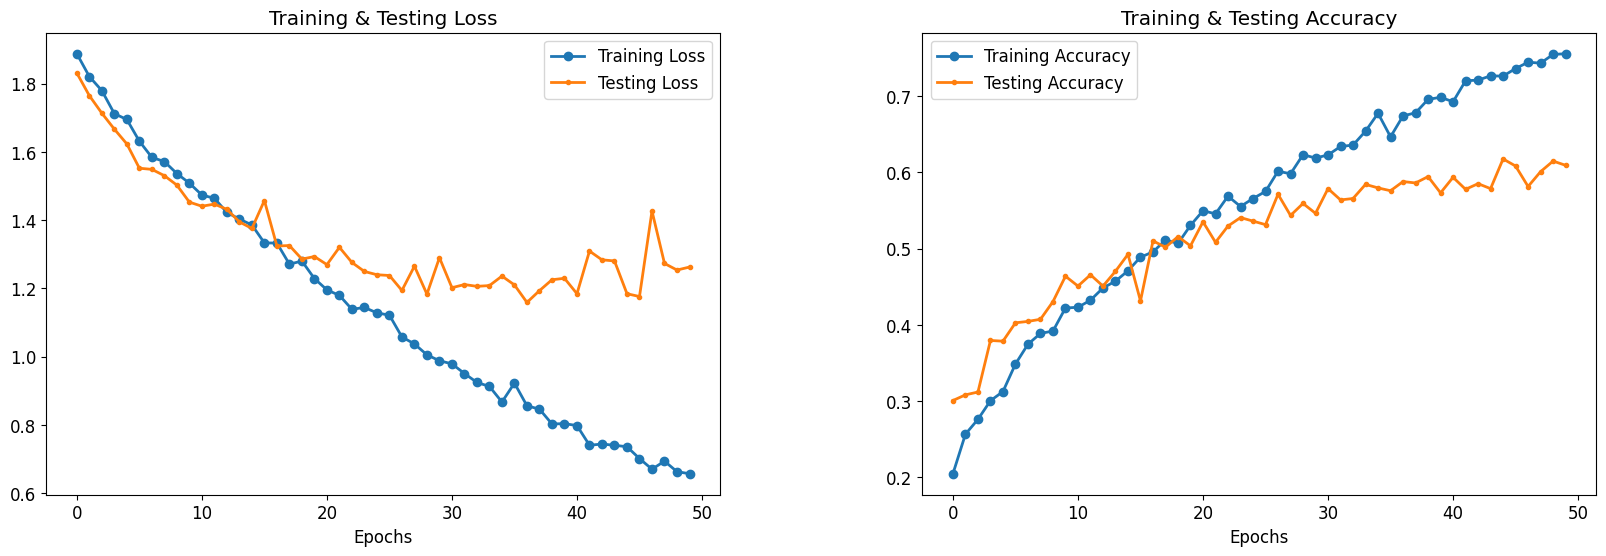

In [14]:
# Plot training & validation accuracy and loss
plt.rcParams.update({'font.size': 12})
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss', marker='o', linewidth=2)
ax[0].plot(epochs, test_loss, label='Testing Loss', marker='.', linewidth=2)
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy', marker='o', linewidth=2)
ax[1].plot(epochs, test_acc, label='Testing Accuracy', marker='.', linewidth=2)
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.subplots_adjust(wspace=0.3)
plt.show()

## Confusion Matrix and Classification Report

Generate a confusion matrix and classification report to evaluate the model's performance.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


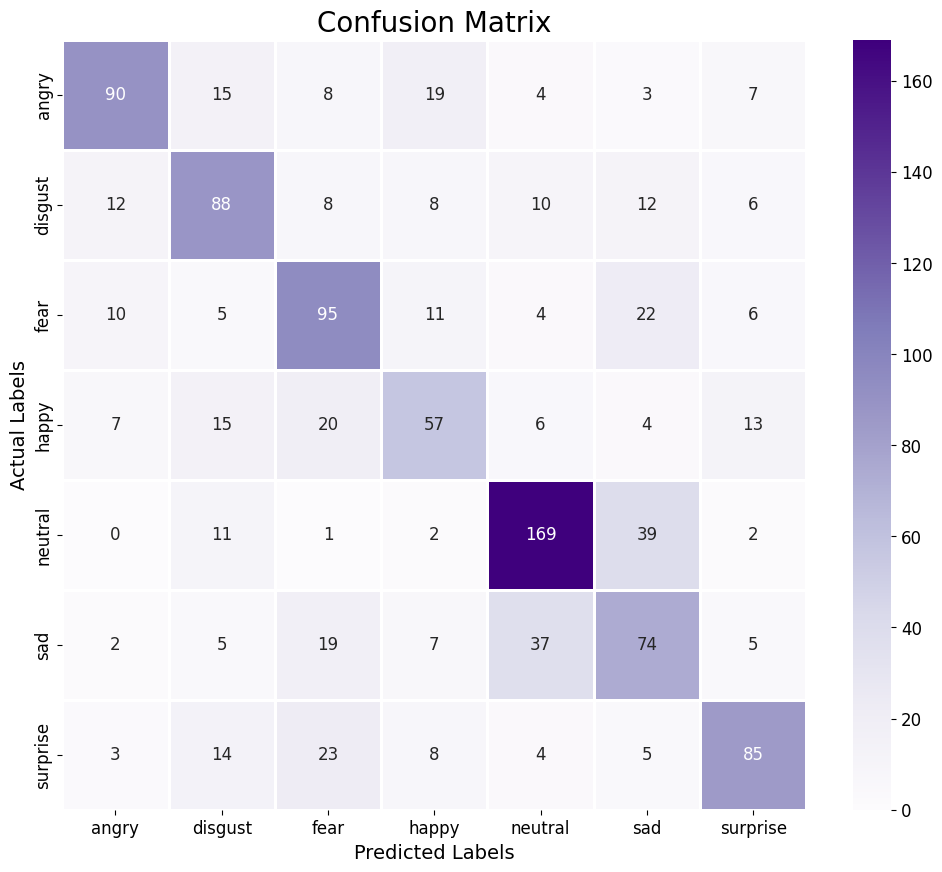

              precision    recall  f1-score   support

       angry       0.73      0.62      0.67       146
     disgust       0.58      0.61      0.59       144
        fear       0.55      0.62      0.58       153
       happy       0.51      0.47      0.49       122
     neutral       0.72      0.75      0.74       224
         sad       0.47      0.50      0.48       149
    surprise       0.69      0.60      0.64       142

    accuracy                           0.61      1080
   macro avg       0.60      0.60      0.60      1080
weighted avg       0.61      0.61      0.61      1080



In [15]:
# Predict the labels for test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=[i for i in encoder.categories_[0]], columns=[i for i in encoder.categories_[0]])
sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Classification Report
print(classification_report(y_test_labels, y_pred, target_names=[i for i in encoder.categories_[0]]))

## Save the Model

Save the trained model to a file for later use.


In [16]:
# Save the model to a file
model.save('emotion_recognition_model.h5')
print("Model saved to 'emotion_recognition_model.h5'")

Model saved to 'emotion_recognition_model.h5'
